In [2]:
### Just remember to provide the data (Mirco) with description
### Describe Methods (of resampling)
## Add an option to plot offline (off browser to say better)
'''
Assume a path structure:

main_folder
|___ data(folder)
|     |__project_data_folder1
                    |__ dati_cebra.jl (file dati)
      |__project_data_folder2
                    |__ dati_mirco.mat (file dati mat file, jle file etc)
|___ project_root(folder)
            |__d_cod_mon_Mirco.py
            |__some_functions.py
            |___EEG_ANN_pipeline(folder)
                    |__data (folder)
                    |__helpers (folder)
                    |__etc....
            |___output directory (folder)
            

'''

############################### METTERE LE PROPRIE DIRECTORIES!!!!!! #######################################
##
####sample notebook.
'''
'''
import os
import sys
import math
from pathlib import Path
import argparse
import logging
import mimetypes
from statsmodels.tsa.seasonal import seasonal_decompose
### load path (use the function in module some functions)
import json
import copy
import time
#import shap
import numpy as np
import yaml
import pickle
import warnings
#import umap 
import openTSNE
import random
import typing
import joblib as jl
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import ParameterGrid, train_test_split,  ParameterSampler, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics
from scipy import stats
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.markers import MarkerStyle
from joblib import Parallel, delayed
import torch
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import optimize as opt
 



In [4]:
# DECLARE  (change to your root)
# 1) PROJECT root directory
#  windows directories
i_dir='J:\\AI_PhD_Neuro_CNR\\Empirics\\GIT_stuff\\AI_for_all\\Contrastive_Stuff'

#  ubuntu directories
#i_dir=r'/media/zlollo/21DB-AB79/AI_PhD_Neuro_CNR/Empirics/GIT_stuff/AI_for_all/Contrastive_Stuff/'

os.chdir(i_dir)
os.getcwd()
from some_functions import *
from model_utils import *
# Random Seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Config GPU
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# 2) NAME of folder containing data (input) directory. 
data_dir="data"
# (specific) project data folder
sub_data="Monkeys_Mirco"

# 3) PIPELINE folder name
pipe_path= "EEG-ANN-Pipeline"

# 4) OUTPUT folder: folder to store processed output
#    (if not existing is created)
out_dir="contrastive_output"

project_root, eeg_pipeline_path, default_output_dir, default_input_dir = setup_paths( data_dir,sub_data,out_dir, pipe_path,change_dir=False)

from data import LabelsDistance, TrialEEG, DatasetEEG, DatasetEEGTorch
from data.preprocessing import normalize_signals
from models import EncoderContrastiveWeights
from data.preprocessing import normalize_signals
from models import EncoderContrastiveWeights
from helpers.model_utils import plot_training_metrics, count_model_parameters, train_model
from helpers.visualization import plot_latent_trajectories_3d, plot_latents_3d
from helpers.distance_functions import *
from layers.custom_layers import _Skip, Squeeze, _Norm, _MeanAndConv
# 
# recall the input dir (declared upwards) and import data
input_dir = default_input_dir
# data format
d_format="mat"
# data_name 
d_name='dati_mirco_18_03_k'
data = load_data(input_dir, d_name,d_format)
print(type(data)) # must be a dictionary


X=data['k_cond2_active_neural']
y_dir=data['k_cond2_active_trial']
y_dir=y_dir.flatten()
#y_pos=data['mix_active_trial']
trial_id=data['k_cond2_active_trial_id']
trial_id=trial_id.flatten()
len_y=len(y_dir)
change_idx = np.where(np.diff(trial_id) != 0)[0] + 1
change_idx
print('ciao')
# the c_t vector tells the starting and endiing points of every trial
c_t=np.concatenate([[0], change_idx,[len_y]], dtype=int)

## list of list of starting and ending points for trials
c_t_list=[]
c_t_list = [(c_t[i], c_t[i+1] - 1) for i in range(len(c_t) - 1)]
n_trials=len(c_t)-1

### check trial length (useful for graphics)
trial_len=np.diff(c_t)
trial_length=trial_len[0]
original_label_order = np.arange(1, 9)  # [1,2,3,4,5,6,7,8]


# recall the input dir (declared upwards) and import data
input_dir = default_input_dir
# data format
d_format="mat"
# data_name
d_name='dati_mirco_18_03_k'
data = load_data(input_dir, d_name,d_format)
print(type(data)) # must be a dictionary

INFO:some_functions:Project root resolved to: J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff
INFO:some_functions:Path to 'EEG-ANN-Pipeline': J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff\EEG-ANN-Pipeline
INFO:some_functions:Input data path: J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\data\Monkeys_Mirco
INFO:some_functions:Output path: J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff\contrastive_output
INFO:some_functions:Output directory ensured: J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff\contrastive_output


try to load: J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\data\Monkeys_Mirco\dati_mirco_18_03_k.mat
<class 'dict'>
ciao
try to load: J:\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\data\Monkeys_Mirco\dati_mirco_18_03_k.mat
<class 'dict'>


In [5]:
#### define X ed Y
'''
Data Structure:
   - X (neural data) is a matrix T(ime)xch(annels)
   - y_... are the associated labels, which can be:
    Discrete or continuous.
    Either matrices or vectors with dimensions T×n, meaning:
        Labels exist for each time point.
        n is the number of label dimensions.

'''
X=data['k_cond2_active_neural']
y_dir=data['k_cond2_active_trial']
y_dir=y_dir.flatten()
#y_pos=data['mix_active_trial']
trial_id=data['k_cond2_active_trial_id']
trial_id=trial_id.flatten()
len_y=len(y_dir)
change_idx = np.where(np.diff(trial_id) != 0)[0] + 1
change_idx
print('ciao')
# the c_t vector tells the starting and endiing points of every trial
c_t=np.concatenate([[0], change_idx,[len_y]], dtype=int)

## list of list of starting and ending points for trials
c_t_list=[]
c_t_list = [(c_t[i], c_t[i+1] - 1) for i in range(len(c_t) - 1)]
n_trials=len(c_t)-1

### check trial length (useful for graphics)
trial_len=np.diff(c_t)
trial_length=trial_len[0]
original_label_order = np.arange(1, 9)  # [1,2,3,4,5,6,7,8]


ciao


In [6]:
########################### RESAMPLING ########################################
 
##### option to resample data a different frequency 

### choose resampling method according to variable type
methods = {
    0: "sum",  
    1: "center"  
    #,2: "mean"
}

## data to resample
l_data=[X,y_dir] 
step=10
overlap=6
Normalize=True
### resampled data, new trials lengths, new trials intervals
resampled,r_trial_lengths,r_trial_indices =  f_resample(l_data,c_t_list, step,
                       overlap, methods, mode="overlapping",normalization=True)

## new Trials' intervals
r_trial=r_trial_indices[0]
start_points=[]
start_points = [x[0] for x in r_trial] + [r_trial[-1][1] + 1]

c_t_resampled=np.array(start_points).flatten()

r_trial_indices[0][1][0]
unique_labels = np.unique(resampled[1])

### Swapping option
### ricampionamento e permutazione delle labels ###
### 6-3, 3-6
#swap_dict = {3: 6, 6: 3}
# Apply mapping back to restore original labels (optional)
#resampled_swapped = swap_labels(resampled[1], swap_dict)
# if np.var(trial_len)==0:    
#     constant_len=True
# else:
#     constant_len=False
# print(constant_len)

####  Number of channels Either first (0) or second dimension (1)
#y_pos=y_pos.flatten()

r_trial_indices[0][1][0]

################## when picking resampled  data ##########################
X_=resampled[0]
len_labs=len(X_)
c_t_=c_t_resampled
y_dir_=resampled[1].reshape(len_labs,1).astype(int)
trial_length=r_trial_lengths[0][0]

################ when picking original data ###########################
#X_=X
#len_labs=len(X_)
#y_dir_=y_dir.reshape(len_labs,1).astype(int)
#♠trial_length=trial_len[0]
# c_t_=c_t

############## if we want to create a time variable to augment the label info
chns=X_.shape[1]
y_time_=list(np.arange(1,trial_length+1))*n_trials
y_time_=np.array(y_time_).reshape(len_labs,1).astype(float)


In [9]:
## sampling frequency (ms)    
fs = 1000
#
normalize=True
trials = [
    TrialEEG(
       X[ c_t_[i]:c_t_[i+1]].T,  # Segnali EEG
          # Labels
         # ,
          [
            ('direction', y_dir_[c_t_[i]:c_t_[i+1]].T),
           ( 'time',y_time_[c_t_[i]:c_t_[i+1]].T        
       ) ],
          # Timepoints
        np.linspace(c_t_[i] / fs, c_t_[i+1] / fs, c_t_[i+1] - c_t_[i])  
    )
    for i in range(len(c_t_) - 1)
]

y_dir_res=[]
for i in range(len(c_t_)-1):
    print(i)
    y_dir_res.append(resampled[1][c_t_[i]:c_t_[i+1]-10].T)
y_dir_res_0 = np.concatenate(y_dir_res, axis=0) 

## check
explore_obj(trials[5])
dataset = DatasetEEG(trials)
#print(dataset)
#print(dataset.trials[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
Esplorazione dell'oggetto: TrialEEG
--------------------------------------------------
eeg_signals: array shape (202, 148)
labels: {'direction': array([[6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6.]],

In [10]:
############################## MODEL PART ####################################

# BUILD the model encoder. (1: cnnd1d simil cebra with skip connections)
def build_model(filters, dropout, latents, num_timepoints, chns, num_units=None, groups=1,normalize=True):
    """
    Build a cnn1d model with:
    - chns: Input channels.
    - filters: convolutional layer(s) filters.
    - latents: outpuit dimension (latent space).
    - num_timepoints: window dimension (test the optimal one).
    - dropout:  dropout.
    - num_units: optional intermediate filters.
    """
    if num_units is None:
        num_units = filters 
    layers = [
        Squeeze(),
        nn.Conv1d(chns, filters, kernel_size=2),
        nn.GELU(),
        _Skip(nn.Conv1d(filters, filters, kernel_size=3), nn.GELU()),
        _Skip(nn.Conv1d(filters, filters, kernel_size=3), nn.GELU()),
        _Skip(nn.Conv1d(filters, filters, kernel_size=3), nn.GELU()),
        nn.Conv1d(filters, latents, kernel_size=3),
    ]

    if normalize:
        layers.append(_Norm())  #

    layers.extend([
        nn.Flatten(),  # 
        #nn.Dropout(dropout),  # 
    ])

    return nn.Sequential(*layers)

# #### Build the model encoder (2: cnn2d)
# # 
# '''
# def build_model(filters, dropout, latents, num_timepoints, chns):
    
#     return nn.Sequential(
#         nn.Conv2d(1, filters, kernel_size=(1, num_timepoints)),
#         nn.BatchNorm2d(filters),
#         nn.Conv2d(filters, filters, kernel_size=(chns, 1), groups=filters),
#         nn.BatchNorm2d(filters),
#         nn.Dropout(dropout),
#         nn.Flatten(),
#         nn.Linear(filters, filters),
#         nn.SELU(),
#         nn.Dropout(dropout),
#         nn.Linear(filters, latents)
#     )
# '''


### Function to generate embeddings after data processing 
# (move to some_functions after generalizing for the labels)
# actually it only returns one label
def generate_embeddings(model, dataset_pytorch, batch_size, device):
    model.eval()
    ## 
    z, labels_position, labels_direction = [], [],[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
    with torch.no_grad():
        for i in range(0, dataset_pytorch.num_trials, batch_size):
            x = dataset_pytorch.eeg_signals[i:i+batch_size].to(device)
            #l_pos = dataset_pytorch.labels['position'][i:i+batch_size,:]
            l_dir = dataset_pytorch.labels['direction'][i:i+batch_size]
            #print(l_dir)
            f_x = model(x)

            z.append(f_x.cpu().numpy())
            #labels_position.append(l_pos.cpu().numpy())
            labels_direction.append(l_dir.cpu().numpy().reshape(-1))

    z = np.concatenate(z)
    #labels_position = np.concatenate(labels_position)
    labels_direction = np.concatenate(labels_direction)
 
    return z ,labels_direction


In [14]:
############# FULL DATASET (No training/test/validation split) ################
'''
split dataset into windows (these are the elements going in the batches)
    ww: mini-sample dimension
    shift: window overlap (shift=1 means sampling 1-10, 2-11, 3-12...)
'''
### 
ww = 10
shift=1
batch_size=1024
dataset_windows=dataset.create_windows(ww, shift)
print(dataset_windows)


#### Convert to PyTorch datasets
dataset_pytorch=DatasetEEGTorch(dataset_windows)
explore_obj(dataset_pytorch)

'''
# Define label distances...multi label must be a dictionary; single label can 
be  either a function or a dictionary with one element
 'direction': direction_distance
  'position':adaptive_gaussian_distance..

the following line includes both position and direction distancethat is both 
lables will be used during training
labels_distance = LabelsDistance({'position': adaptive_gaussian_distance,'direction':direction_distance})

the following line only includes direction distance in the process
labels_distance = LabelsDistance({'position': adaptive_gaussian_distance})

'''
labels_distance = LabelsDistance({'direction':direction_distance})
#labels_distance = LabelsDistance({'position': adaptive_gaussian_distance})

explore_obj(labels_distance)
## deliver to cuda devices (if any available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_pytorch.to_device(device)
device

dataloader_ = DataLoader(dataset_pytorch, batch_size=batch_size, shuffle=False)
## explore the dataloader
for batch in dataloader_:
    #►pippo.append(batch)
    print(type(batch[1])) 
    print(batch[0].shape)       
    break 


Labels type in __str__: multi_label
num_trials               :  8832
num_channels (per trial) :  202
timepoints (per trial)   :  10 (fix)
labels_type              :  multi_label
labels_format            :  {'direction': 'ndarray', 'time': 'ndarray'}

{'direction': 'ndarray', 'time': 'ndarray'}
Esplorazione dell'oggetto: DatasetEEGTorch
--------------------------------------------------
_is_protocol: False
create_labels: <bound method DatasetEEGTorch.create_labels of <data.eeg_dataset_torch.DatasetEEGTorch object at 0x000001EAA2E659C0>>
Labels type in __str__: multi_label
dataset_original: num_trials               :  8832
num_channels (per trial) :  202
timepoints (per trial)   :  10 (fix)
labels_type              :  multi_label
labels_format            :  {'direction': 'ndarray', 'time': 'ndarray'}

eeg_signals: shape torch.Size([8832, 1, 202, 10])
label_names: length 2
labels: {'direction': tensor([[1.],
        [1.],
        [1.],
        ...,
        [8.],
        [8.],
        [8.]

Model architecture: EncoderContrastiveWeights(
  (layers): Sequential(
    (0): Squeeze()
    (1): Conv1d(202, 64, kernel_size=(2,), stride=(1,))
    (2): GELU(approximate='none')
    (3): _Skip(
      (module): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (4): _Skip(
      (module): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (5): _Skip(
      (module): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (6): Conv1d(64, 3, kernel_size=(3,), stride=(1,))
    (7): _Norm()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
)
Model has 63556 parameters.
cuda


100%|██████████| 3000/3000 [06:50<00:00,  7.31it/s, alignement=-6.97, uniformity=6.76, loss=-0.207]


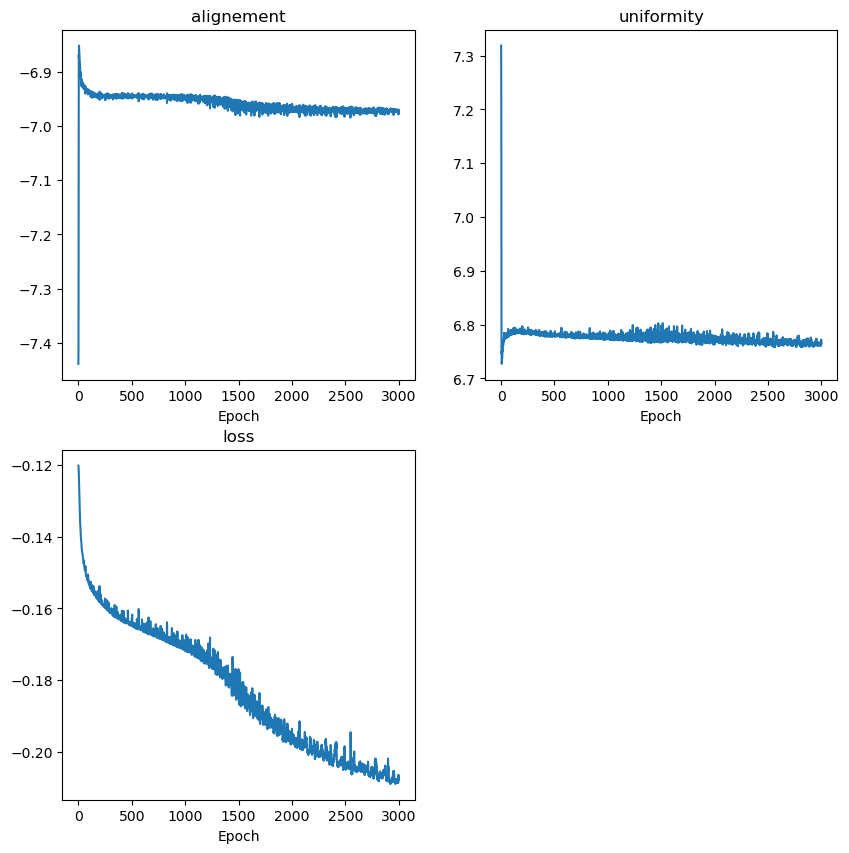

In [16]:
#PARAMETERS
## Validation/test split
#valid_split = 0.15
## window of each mini batch
dropout = 0.5
## network hidden layers channles
filters = 32
## output channels (latents)
latents = 3
# learning rate
l_rate = 0.0001
#sigma_pos = 0.016
#sigma_time = 0.025
batch_size=1024
filters=64
n_h_u=filters
epochs=3000
## temperature
tau=1.266

model = EncoderContrastiveWeights(
    ### define the network (recall the parameters defined from line 209)
    layers=build_model(n_h_u, dropout, latents, ww, chns, normalize=normalize),
    ### choose between infoNCE, supervised contrastive, weeighted contrastive loss
    #loss_type="weighted_contrastive",
    # 
    labels_distance=labels_distance,
    #labels_distance=None,
    ## If we use the labels, choose some weights
    ## if we have more label and want a different weight for every label
    ## just put a weight for each label; if we have one label or want just the 
    ## same weight for each label one value is ok
    labels_weights=[1],
    #labels_weights=None,
    temperature=tau,
    train_temperature=False,
    ### time contrastive loss asks either offset or window
    #positive_offset=5,  # Offset per i positivi (se usi offset)
    #positive_window=0 
    
    )

model.to(device)

print("Model architecture:", model)
print(f"Model has {count_model_parameters(model)} parameters.")
#print(f"subject is {name}")
print(f"{device}")

# Train and evaluate the model
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

# train on a batch (just to check if everything is ok)
#batch = next(iter(dataloader_))
#loss_dict = model.process_batch(batch, optimizer)

### model training
metrics = train_model(model, optimizer, dataloader_, epochs=epochs)
plot_training_metrics(metrics)


## GENERATE EMBEDDINGS and recover the label info 
#, l_pos_0 
z_0, l_dir_0= generate_embeddings(model, dataset_pytorch, batch_size, device)


In [17]:
### generate 3d plot
### DATI RESAMPLED
trial_length_r=r_trial_lengths[0][0]
#trial_length=trial_len[0]
constant_len=True
###define the trajectories. First monkey is 1-8, second is 9-16
# first
n_traj=np.arange(8)
# second
#n_traj=np.arange(8)+9
#

c_s="maroon"
title_=title_=f"K_CL_cond2_shift_{overlap}_sum_nhu_{n_h_u}_temp{tau}_iters{epochs}.html"

output_folder = default_output_dir
results_list=[]
plot_direction_averaged_embedding(
            z_0,
            y_dir_res_0,
            original_label_order,
            c_s,
            output_folder,
            title_,
            trial_length_r,
            constant_length=True,
            ww=10,
            label_swap_info=None
        ) 



(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
(8832,)
Trial average shape: (138, 3)
(138, 3)
